# FixationGrower Initial Plots

**Goal**: Given new trials table, see how multi-day plotting works with FixationGrower protocol and make any updates as needed. 

**Notes**: May need to consider making a new visualization class for this purpose, or at least some visualization logic that utilizes the "protocol" field of the trials table.

In [21]:
import sys

sys.path.append("../")

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

from multiplot_summaries import *

%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
animal_id = ["R033"]
date_min = "2024-07-16"

# Create a dataframe with all the trials
trials_df = create_trials_df_from_dj(animal_id, date_min)
days_df = create_days_df_from_dj(animal_id, date_min)

[2024-07-17 16:35:49,109][WARNING]: MySQL server has gone away. Reconnecting to the server.


fetched 1 sessions for R033 between 2024-07-16 and 2024-07-16
Fetched data from SessionAggDate table from 2024-07-16 to 2024-07-16  
No new data from today, 2024-07-17 to add to SessionAggDate.


In [23]:
for (date, animal_id), sub_df in trials_df.groupby(["date", "animal_id"]):
    pass

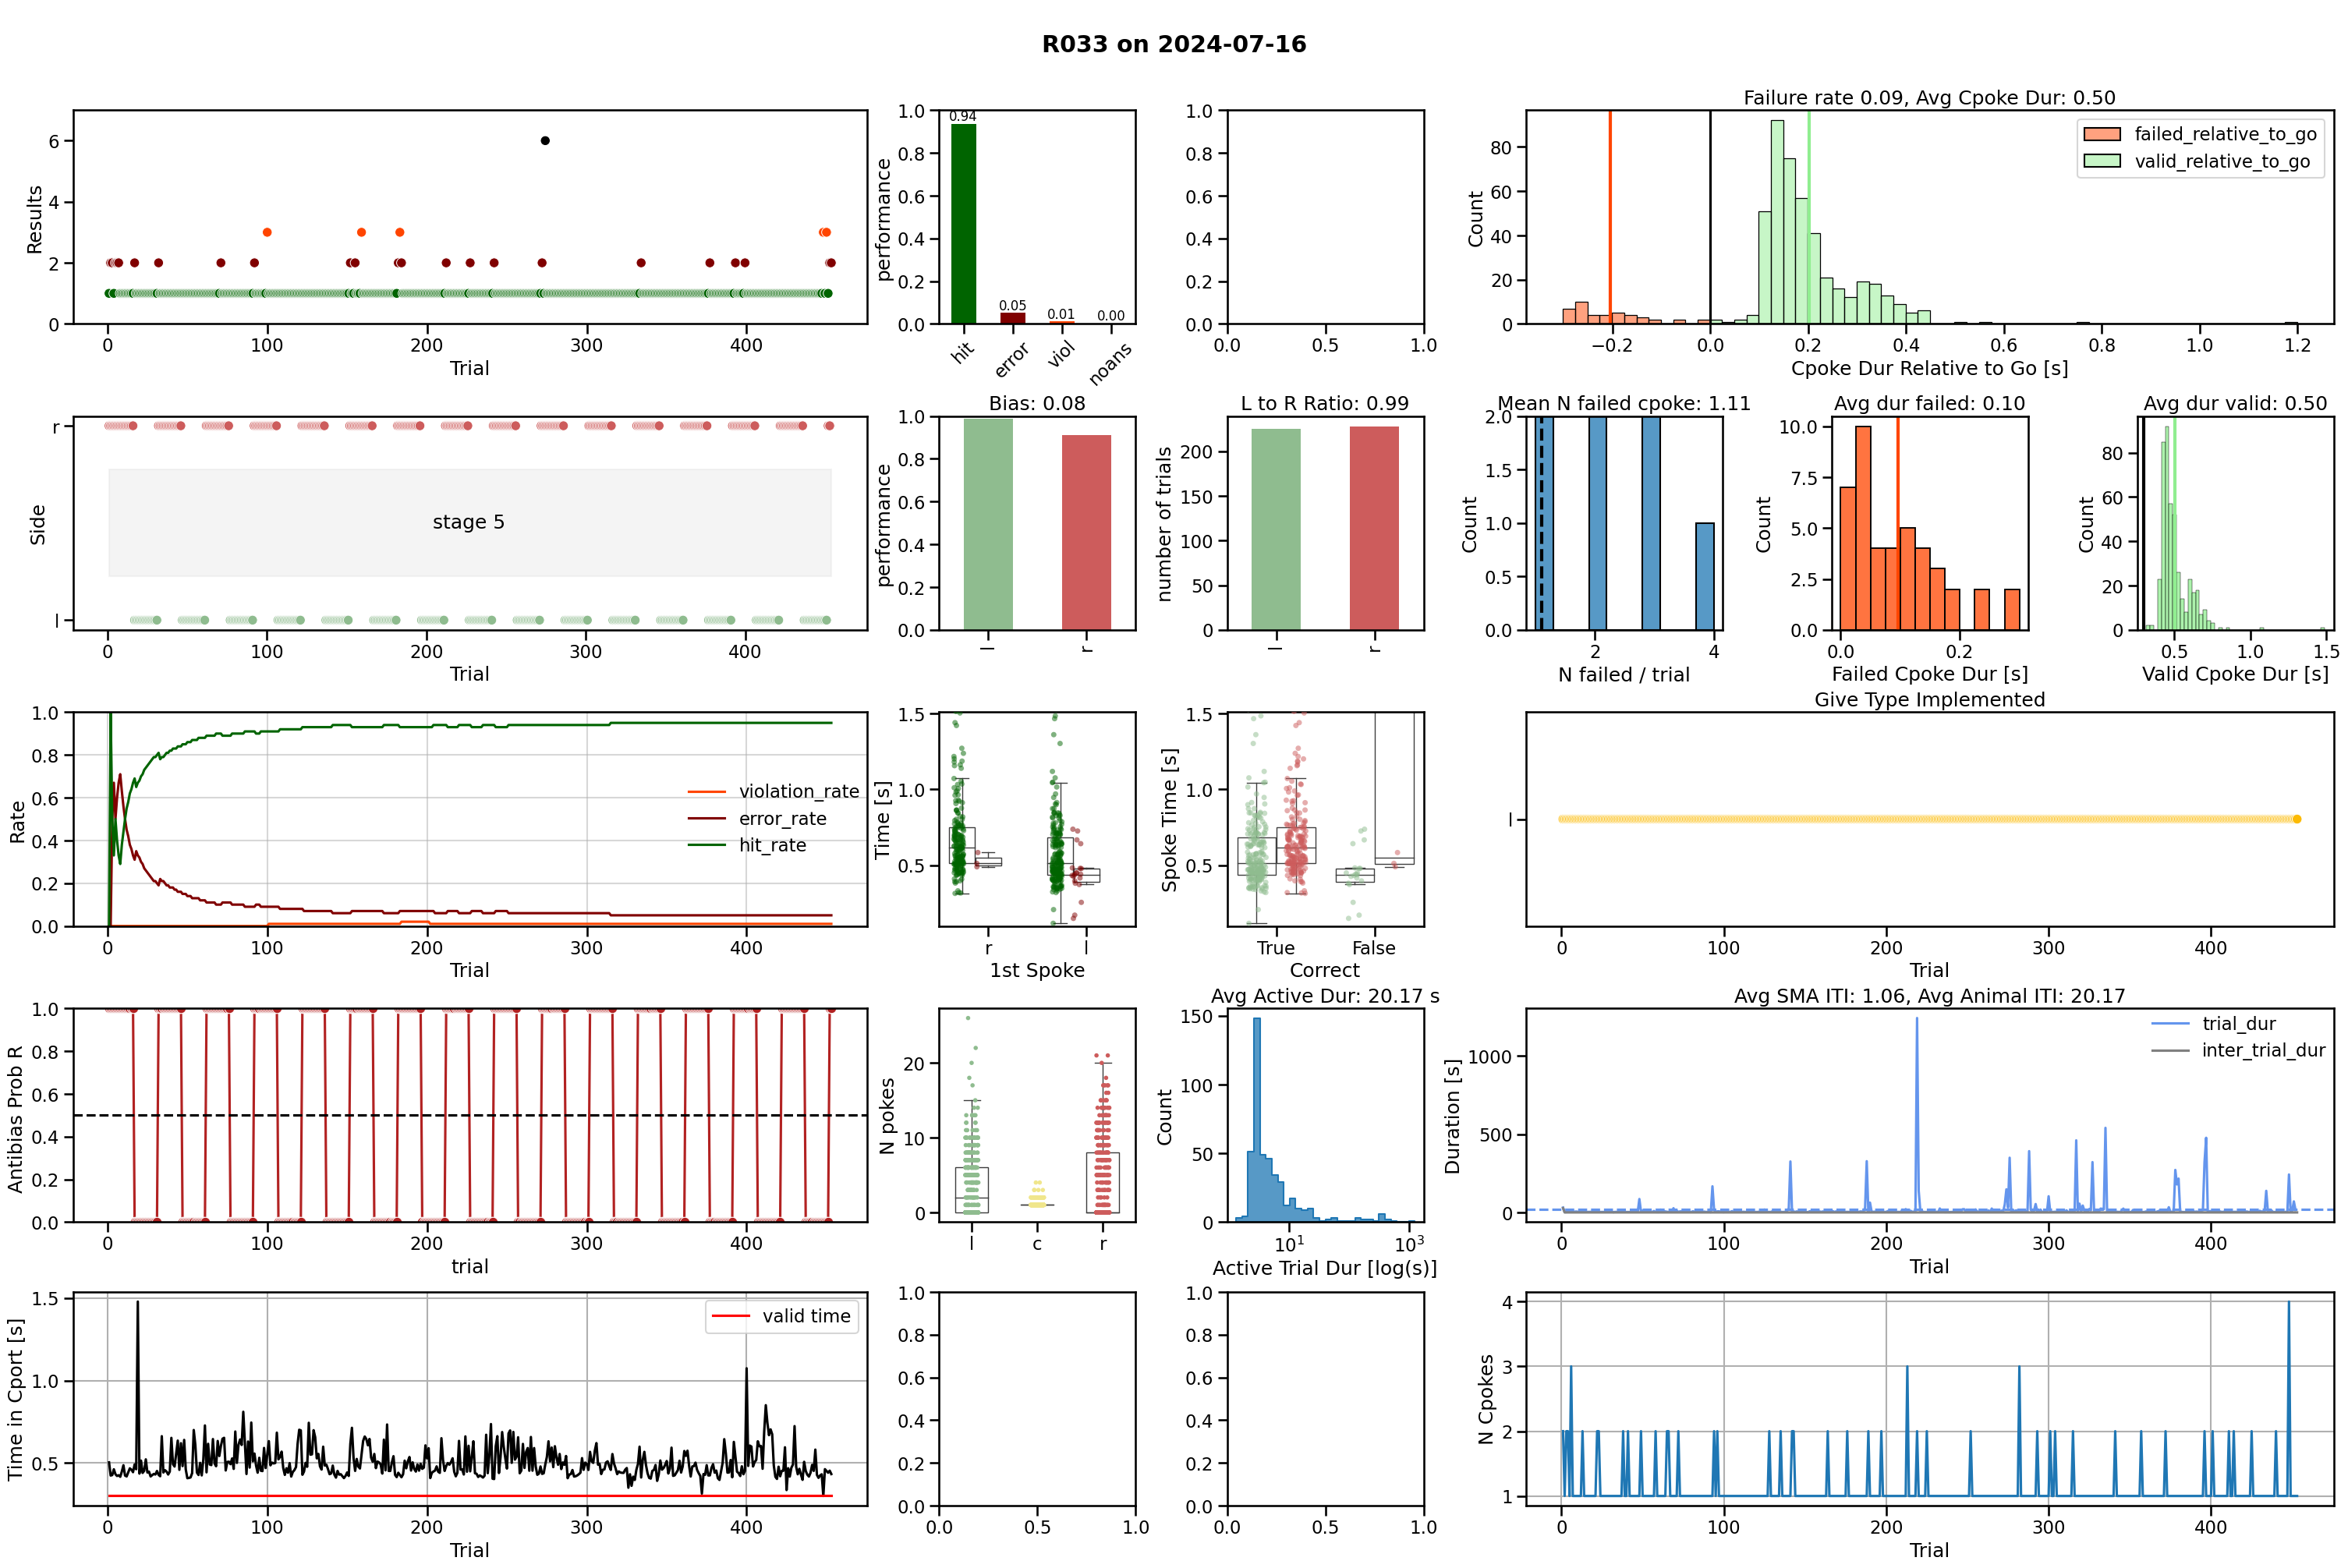

In [26]:
multiplot_cpoke_pre_sounds(sub_df)

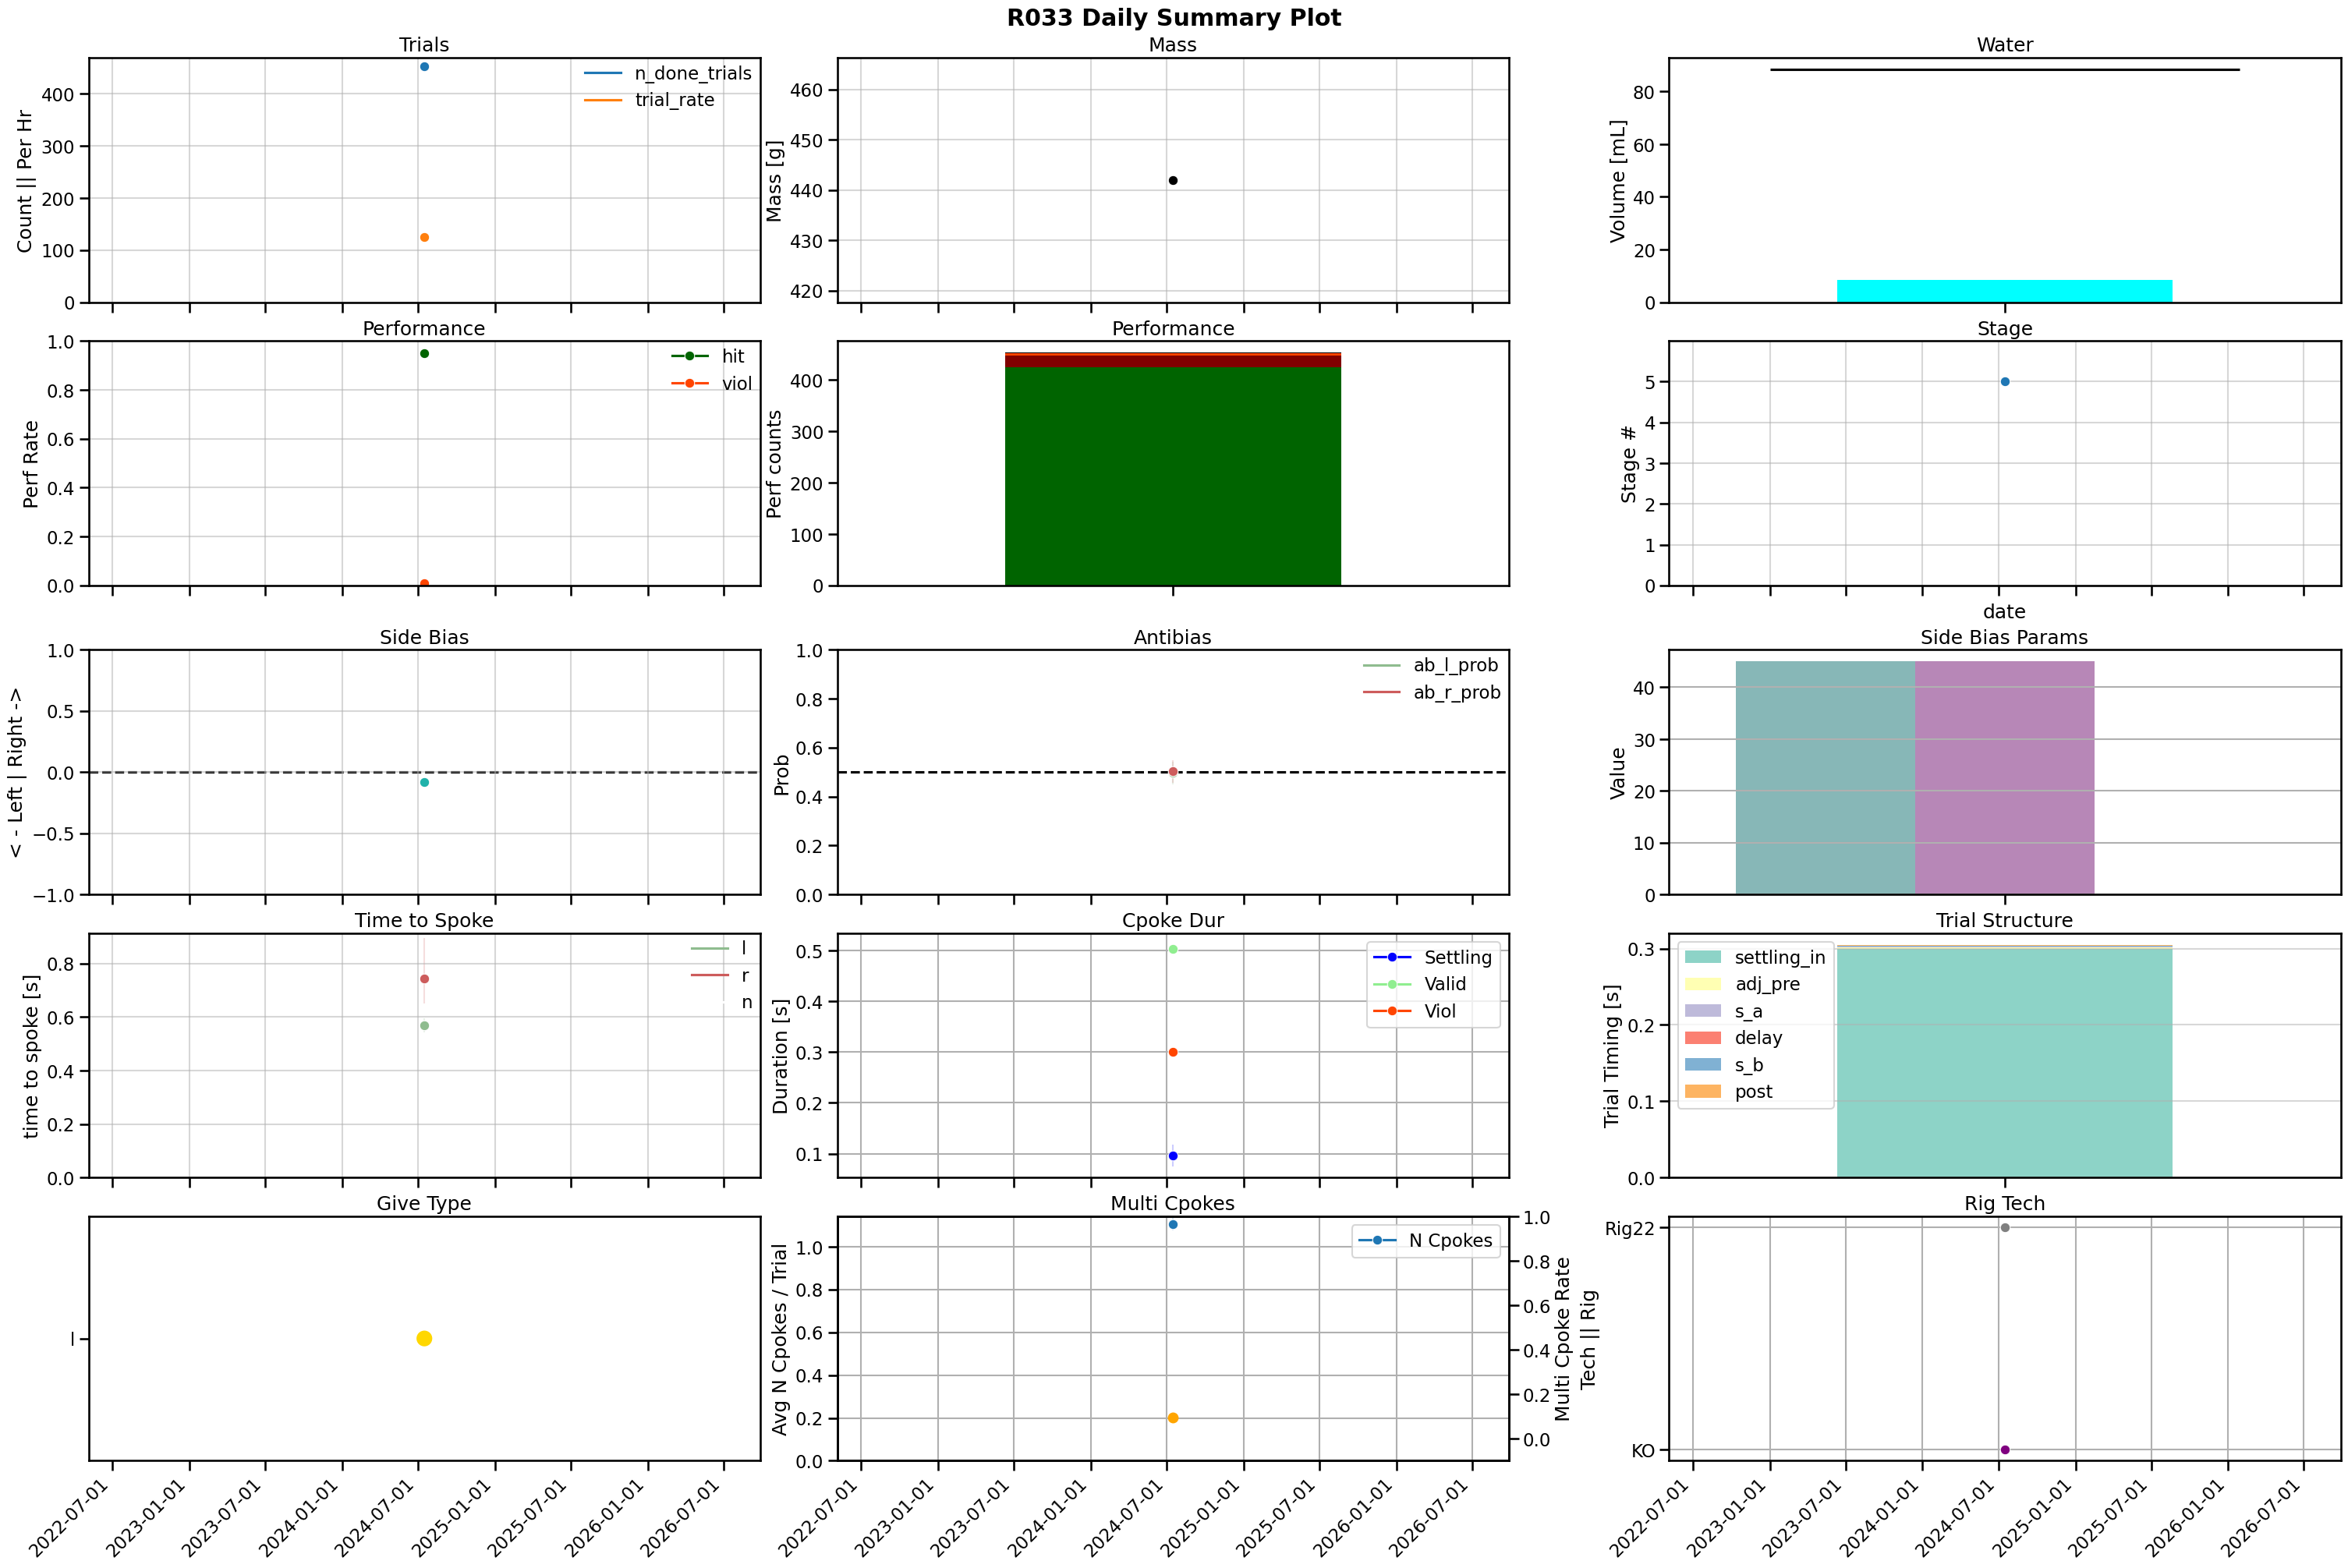

In [27]:
multiplot_multi_day_summary(animal_id, days_df, trials_df)